## Holonomic RRT

In [1]:
!mkdir Results

A subdirectory or file Results already exists.


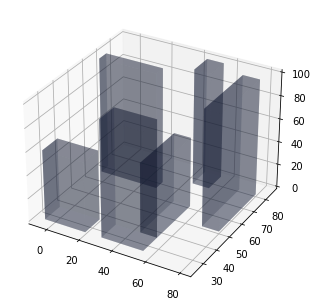

129.69146401530816
[22.86579627332903, 60.40864783128905, 3.5494153084622644]
[22.86579627332903, 60.40864783128905, 3.5494153084622644]
[10, 50, 0]
------------
iter 0
131.10899645846428
[10.0, 50.0, 18.823840000000004]
[10.0, 50.0, 18.823840000000004]
[10, 50, 0]
------------
iter 1
125.42130801812978
[28.06428660165412, 44.830617305944145, 13.327646530127982]
[28.06428660165412, 44.830617305944145, 13.327646530127982]
[10.0, 50.0, 18.823840000000004]
------------
iter 2
126.37815612302774
[22.309956317229158, 60.743137020370675, 8.377982086050189]
[22.309956317229158, 60.743137020370675, 8.377982086050189]
[28.06428660165412, 44.830617305944145, 13.327646530127982]
------------
iter 3
116.04850701852415
[32.1312903193162, 39.982823266343026, 27.480811336388417]
[32.1312903193162, 39.982823266343026, 27.480811336388417]
[28.06428660165412, 44.830617305944145, 13.327646530127982]
------------
iter 4
148.1987273453328
[7.359355197261803, 39.24114379920761, 1.5676114763000397]
[7.359355

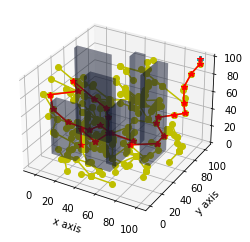

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as Axes3D
import math


c = math.cos
s = math.sin 

class holonomic_RRT:
    def __init__(self,start_config,goal):
        (x0,y0,z0) = start_config
        self.xg = goal[0]
        self.yg = goal[1]
        self.zg = goal[2]
        self.x = []
        self.y = []
        self.z = []
        self.x.append(x0)
        self.y.append(y0)
        self.z.append(z0)
        self.goal1 = goal 
        
        self.x_start = start_config[0]
        self.y_start = start_config[1]
        self.z_start = start_config[2]

        self.start = [ self.x_start ,self.y_start , self.z_start  ]

        
        self.yaw = -np.pi/2 
        
        self.m = 0.5 
        self.g = 9.8 
        self.RectCenters = []
        
        self.xlen = []
        self.ylen = []
        self.zlen = [] 
        
        self.xrange = [0, 100 ]
        self.yrange = [0, 100 ]
        self.zrange = [ 0 , 100 ]
        
        self.rsafe = 5 
        
        self.maxIters = 1500
        
        self.Tree = {} 
        
        self.AllStates = []

        self.goal_radius  = 1  ## radius before the goal to stop planning 
        self.goal_bias = 10 ## add goal as local goal once 30 iterations 

        self.numEdgeCheck = 10 

        self.AccToAngles = {} 

        self.EdgeToAngles = {} 
        
        
        #add other parameters required
        
    def acceleration_command(self,theta,phi,T):
        """
        Derive ax,ay,az from theta,phi,T
        """
        
        ax =  ( - c(phi)*s(theta)*c(self.yaw) - s(phi)*s(self.yaw) )*T/self.m
        ay =  ( - c(phi)*s(theta)*s(self.yaw) + s(phi)*c(self.yaw) )*T/self.m
        az = ( self.g - ( c(phi)*c(theta))*T/self.m )

        A = [ ax , ay, az ]

        self.AccToAngles[str(A)] = [ phi , theta , T]
        
        return ax, ay , az 
               
        
    def acceleration_control(self , X , dt , acc ):
        """
        Convert accelerations to position
        """
        
        x = X[0] + 0.5*acc[0]*(dt)**2 
        y = X[1] + 0.5*acc[1]*(dt)**2 
        z = X[2] + 0.5*acc[2]*(dt)**2 
        
        return [ x,y,z ]
        
    # implement holonomic RRT 
    
    def TransformQpt( self, Qpt ):
        
        TransformedQpt = [] 
        
        for Cent in self.RectCenters:
            
            diff = np.asarray(Qpt) - np.asarray(Cent)
            TransformedQpt.append(diff )
        
        return TransformedQpt

    def TransformQpt2( self, Qpt, Center ):

        diff = np.asarray(Qpt) - np.asarray(Center)

        return diff


    
    def RectangularSDF( self , Qpt, Xlength, Ylength , Zlength ):
        
        R = np.asarray( [  Xlength, Ylength , Zlength ])
        
        d =  np.linalg.norm( np.maximum( np.abs(Qpt) - R , np.zeros(3) ) )
        
        return d
    
    
    def DetectCollision( self,  Qpt ):
        
        numRects = len( self.xlen )
        distance = []
        
        for i in range(numRects  ):
            Qpt_transformed =  self.TransformQpt2(Qpt ,self.RectCenters[i] )  ##self.TransformQpt(Qpt)
            
            d= self.RectangularSDF( Qpt_transformed ,self.xlen[i] , self.ylen[i] , self.zlen[i]  )
            distance.append( d )
        
        colsestDistance = np.amin(distance  )
        
        return colsestDistance
    
    def IsinMap( self , Qpt ):
        
        
        InMap = False 
        if ( Qpt[0] <= self.xrange[1] and Qpt[0] >= self.xrange[0 ] and  Qpt[1] <= self.yrange[1] and Qpt[1] >= self.yrange[0 ]  
           and Qpt[2] <= self.zrange[0] and Qpt[2] >= self.zrange[1]  ):
            InMap = True 

        return InMap
        
    
    def CheckValidPoint( self, Qpt ):
        
        collisionDistance = self.DetectCollision(Qpt)
        # inMap = self.IsinMap(Qpt )
        isValid = False 
        
        if( collisionDistance > self.rsafe  ):
            
            isValid =  True
        else:
            isValid = False 
        
        return isValid
    
    def PropagateState( self, Theta_in , Phi_in , T_in , time  , CurrState ):
        
        numCntrls = len( Phi_in )
        ProState = []
        
        for th in Theta_in:
            for ph in Phi_in:
                for T in  T_in :
                    cnt =0 
                    for dt in time:
                        
                        ax, ay, az = self.acceleration_command( th, ph , T)
                        TempState = self.acceleration_control( CurrState , dt , [ax, ay, az   ])
                        if(  not self.CheckValidPoint( np.asarray( TempState) ) or (TempState[2] < 0  ) ):
                        	break 
                        cnt +=1 
                        if( cnt %3 == 0):
                            ProState.append( TempState )
                            TempEdge = self.GetEdge(CurrState, TempState)
                            self.EdgeToAngles[str(TempEdge)] = [ th, ph, T ]

                    ProState.append( TempState )

                    TempEdge = self.GetEdge(CurrState, TempState)
                    self.EdgeToAngles[str(TempEdge)] = [ th, ph, T ]
        
        return ProState
                        
    
    def SampleRandomConfig(  self ): ## sample a random goal 
        
        isPtvalid = False 
        
        while not isPtvalid:
            
            xval = np.random.randint( low = self.xrange[0] , high = self.xrange[1]   )
            yval = np.random.randint( low = self.yrange[0] , high = self.yrange[1]   )
            zval = np.random.randint( low = self.zrange[0] , high = self.zrange[1]   )
            
            Q = np.asarray( [ xval , yval , zval ] )
            isPtvalid = self.CheckValidPoint( Q )
        
        return Q 
    
    def GetOptimalState( self, ProStates , LocalGoal ):
        
        dist = []
        P = np.asarray(ProStates)


        print(np.shape(P))
        
        for PS in ProStates:
            
            d = np.linalg.norm(PS - LocalGoal)
            dist.append(d)
        
        index = np.argmin( dist )
        
        return ProStates[index]


    def GetOptimalStateVectorized( self, ProStates ,LocalGoal ):

        P = np.asarray(ProStates)
        P = P.T

        LocalGoal = np.reshape(LocalGoal, (3, 1) )

        NewPts = P - LocalGoal
        dist = np.linalg.norm(NewPts ,axis =0 )
        index = np.argmin(dist)

        return ProStates[index]

    
    def GetAllStates( self , ProStates ):
        
        for P in ProStates:
            self.AllStates.append( P)
                    
        
    def showpath(self):
        """
        Create a new directory (say nonholonomic_path) and save snapshots of the robot moving along the
        trajectory found by RRT at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
    
     
    def GetEdge( self, parent , child ):
        
        X = [ parent[0] ,  child[0] ]
        Y = [ parent[1] ,  child[1] ]
        Z = [ parent[2] ,  child[2] ]
        return X, Y , Z 


    def GoalReached( self , CurrState ):

        dist_from_goal = np.linalg.norm( np.asarray(CurrState ) - np.asarray(self.goal1) )
        Goal_Reached = False
        print( dist_from_goal )
        print( CurrState )
        if( dist_from_goal < self.goal_radius ):
            Goal_Reached =  True 

        return Goal_Reached 


    def SetParentChildMap( self,  ProStates , parent ):

    	for P in ProStates:

    		self.Tree[str(P)] = parent


    def IsEdgeValid( self , parent ,child ):

        delval = (np.asarray(child) - np.asarray(parent) )/ self.numEdgeCheck
        isValid = True 

        for i in range(self.numEdgeCheck):
            for j in range(self.numEdgeCheck):
                for k in range(self.numEdgeCheck):

                    x = parent[0] + i*delval[0]
                    y = parent[1] + j*delval[1]
                    z = parent[2] + k*delval[2]

                    Pt = [ x,y,z ]

                    if( not self.CheckValidPoint(Pt) ):
                        isValid = False
                        break

        return isValid

    def GetFinalTraj( self, FinalState ):

        Path = [] 
        Path.append(FinalState)


        terminate = False

        while not terminate:
            PrevNode = self.Tree[str(FinalState)]
            Path.append(PrevNode)
            FinalState = PrevNode

            if( PrevNode == self.start ):
                terminate = True

        return Path


    def showtree(self , Theta_in , Phi_in , T_in , Time ):
        """
        Create a new directory (say nonholonomic_tree) and save snapshots of the evolution of the RRT tree
        at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        
        parent = [self.x_start , self.y_start , self.z_start]
        Paths = [] 
        fig = plt.figure()
        ax = plt.axes(projection='3d')

        file1 = open("Controls_result.txt", "w") 



        cnts = []
        PHI= []
        THETA =[]
        THRUST = [] 
        
        obstacles = [[-5, 25, 0, 20, 35, 60],
                     [30, 25, 0, 55, 35, 100],
                     [45, 35, 0, 55, 60, 60],
                     [45, 75, 0, 55, 85, 100],
                     [-5, 65, 0, 30, 70, 100],
                     [70, 50, 0, 80, 80, 100]]
        
        fig.add_axes(ax)
        cnt =0 

        ImgCnt = 0 
        for box in obstacles:
            X, Y, Z = self.cuboid_data(box)
            xcent  = (box[0] + box[3])/2
            ycent = (box[1] + box[4])/2
            zcent = (box[2] + box[5])/2
            
            
            x_len = (box[3] - box[0])/2
            y_len = (box[4] - box[1])/2
            z_len = (box[5] - box[2])/2
            
            self.xlen.append( x_len )
            self.ylen.append( y_len )
            self.zlen.append( z_len )
            
            self.RectCenters.append( [xcent, ycent, zcent] )
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,color=(0.1, 0.15, 0.3, 0.2),zorder = 1)  

        
        for i in range( self.maxIters ):  ## Optimal State is the child but the parent is not the previous expanding node 
            Prostate = hn_RRT.PropagateState(  Theta_in , Phi_in , T_in , Time  , parent )
            self.SetParentChildMap( Prostate , parent)

            hn_RRT.GetAllStates( Prostate )
            LocalGoal = hn_RRT.SampleRandomConfig()
            # LocalGoal = np.asarray(self.goal1)
            if( i != 0 and int(i%self.goal_bias) == 0 ):
            	LocalGoal = np.asarray(self.goal1)

            OptimalState = hn_RRT.GetOptimalStateVectorized(self.AllStates , LocalGoal) #hn_RRT.GetOptimalState(self.AllStates , LocalGoal )

            Goal_Reached =  self.GoalReached(OptimalState)


            if( Goal_Reached ):

                print( "Goal Reached ")
                Path = self.GetFinalTraj( OptimalState  )
                print("=============")
                print(Path)
                print("============")
                PathLen = len(Path)

                for i in range(PathLen-1):
                    X , Y ,Z   =  self.GetEdge( Path[i] , Path[i+1]  )
                    ax.plot3D( X , Y ,Z , marker = '*' , color='r' )
                

                for i in range(PathLen -1 ):

                    PlotEdge2   =  self.GetEdge( Path[i+1] , Path[i]  )
                    # PlotEdge2 = [PlotEdge[1] , PlotEdge[0] ]

                    ph, th, T = self.EdgeToAngles[ str(PlotEdge2 )]
                    
                    file1.write( str(ph) +" " )
                    file1.write( str(th) + " " )
                    file1.write( str(T) +" " )
                    file1.write( str(i) +" " )
                    file1.write("\n")
                    # cnts.append(i)
                    # PHI.append(ph)
                    # THETA.append(th)
                    # THRUST.append(T)
                file1.close() 

                # plt.plot(PHI , cnts )
                # plt.plot(THETA , cnts)
                # plt.plot(THRUST , cnts)
                
                break 
            # self.Tree[str(OptimalState) ] = parent
            
            X , Y ,Z   =  self.GetEdge(self.Tree[str(OptimalState)] , OptimalState  )

            if( not self.IsEdgeValid(self.Tree[str(OptimalState)] , OptimalState  ) ):
                continue 


            print( OptimalState  )
            print( self.Tree[str(OptimalState)] )

            print("------------")
            parent = OptimalState
            
            print( "iter " + str(i) )
            ax.plot3D( X , Y ,Z , marker = 'o' , color='y')
            plt.xlabel("x axis")
            plt.ylabel(" y axis")
            # plt.zlabel(" z axis ")
            ax.plot3D( self.xg , self.yg , self.zg , marker = 'P' , color='c' )
            # ax.plot3D( OptimalState[0] , OptimalState[1] , OptimalState[2] , marker='*', color='black')

            plt.savefig( "Results/"+str(ImgCnt)+".png")
            ImgCnt += 1
        
        plt.show()
        
        
    def cuboid_data(self,box):
        l = box[3] - box[0]
        w = box[4] - box[1]
        h = box[5] - box[2]
        x = [[0, l, l, 0, 0],
             [0, l, l, 0, 0],
             [0, l, l, 0, 0],
             [0, l, l, 0, 0]]
        y = [[0, 0, w, w, 0],
             [0, 0, w, w, 0],
             [0, 0, 0, 0, 0],
             [w, w, w, w, w]]
        z = [[0, 0, 0, 0, 0],
             [h, h, h, h, h],
             [0, 0, h, h, 0],
             [0, 0, h, h, 0]]
        return box[0] + np.array(x), box[1] + np.array(y), box[2] + np.array(z)
        
    def test_env(self):
        # 3D boxes   lx, ly, lz, hx, hy, hz
        obstacles = [[-5, 25, 0, 20, 35, 60],
                     [30, 25, 0, 55, 35, 100],
                     [45, 35, 0, 55, 60, 60],
                     [45, 75, 0, 55, 85, 100],
                     [-5, 65, 0, 30, 70, 100],
                     [70, 50, 0, 80, 80, 100]]
        
        # create map with obstacles
        fig = plt.figure()
        ax = Axes3D.Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        cnt =0 
        for box in obstacles:
            X, Y, Z = self.cuboid_data(box)
            xcent  = (box[0] + box[3])/2
            ycent = (box[1] + box[4])/2
            zcent = (box[2] + box[5])/2
            
            
            x_len = (box[3] - box[0])/2
            y_len = (box[4] - box[1])/2
            z_len = (box[5] - box[2])/2
            
            self.xlen.append( x_len )
            self.ylen.append( y_len )
            self.zlen.append( z_len )
            
            self.RectCenters.append( [xcent, ycent, zcent] )
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,color=(0.1, 0.15, 0.3, 0.2),zorder = 1)
            

            
        plt.show()
    
    def PlotPath( self, path ):

            obstacles = [[-5, 25, 0, 20, 35, 60],
                         [30, 25, 0, 55, 35, 100],
                         [45, 35, 0, 55, 60, 60],
                         [45, 75, 0, 55, 85, 100],
                         [-5, 65, 0, 30, 70, 100],
                         [70, 50, 0, 80, 80, 100]]

            # create map with obstacles
            fig = plt.figure()
            ax = Axes3D.Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            cnt =0 
            for box in obstacles:
                X, Y, Z = self.cuboid_data(box)
                xcent  = (box[0] + box[3])/2
                ycent = (box[1] + box[4])/2
                zcent = (box[2] + box[5])/2


                x_len = (box[3] - box[0])/2
                y_len = (box[4] - box[1])/2
                z_len = (box[5] - box[2])/2

                self.xlen.append( x_len )
                self.ylen.append( y_len )
                self.zlen.append( z_len )

                self.RectCenters.append( [xcent, ycent, zcent] )
                ax.plot_surface(X, Y, Z, rstride=1, cstride=1,color=(0.1, 0.15, 0.3, 0.2),zorder = 1)
            


            plt.show()            
            

class Utilities:
    
    def __init__(self, thetaRange , phiRange , tRange ):
        
        self.ThetaRange = thetaRange
        self.PhiRange = phiRange
        self.TRange = tRange
        
    
    def SampleInputControls( self , numSamples ):
        
        d_theta = int( self.ThetaRange[1] - self.ThetaRange[0] ) / numSamples
        d_phi = int( self.PhiRange[1] - self.PhiRange[0] ) / numSamples
        d_t =  int( self.TRange[1] - self.TRange[0] ) / numSamples
        
        Theta_in = []
        Phi_in =[]
        T_in = [] 
        for i in range( numSamples ):
            th = self.ThetaRange[0] + i*d_theta
            ph = self.PhiRange[0] + i*d_phi
            t = self.TRange[0]  + i*d_t 
            Theta_in.append( th*np.pi/180)
            Phi_in.append( ph*np.pi/180)
            T_in.append( t )
        
        
        return Theta_in , Phi_in , T_in
    
        
        
start = (10, 50, 0)
goal = (100,100,100)
hn_RRT = holonomic_RRT(start,goal)
hn_RRT.test_env()

start = [start[0],start[1], start[2]] 
goal = [ goal[0], goal[1] , goal[2] ]

maxIters = 50
thetaRange , phiRange , tRange = [ - 60, 60 ] , [-60, 60] , [ 0 , 10 ]
numSamples = 5 
Cntrl = Utilities(thetaRange , phiRange , tRange )
Theta_in , Phi_in , T_in = Cntrl.SampleInputControls( numSamples )

Time = np.arange( 0.01, 2 , 0.05 )
CurrState = start

hn_RRT.showtree( Theta_in , Phi_in , T_in , Time )